# TECO-PSDA-ExerciseSheet1-credit-2024
Group 2

In [4]:
#!pip install xgboost

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
#from sklearn.preprocessing import OneHotEncoder
import IPython
import scipy.stats as scs
from itertools import product
#import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns #Visualization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


## 0. Load Data

In [68]:
# dir = 'TECO-PSDA-ExerciseSheet1-credit-2024/'
test_data = pd.read_csv('credit_test.csv', index_col=0)
train_data = pd.read_csv('credit_train.csv', index_col=0)

## 1. Data Exploration

In [71]:
num_rows, num_columns = train_data.shape
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)
train_data.head()

Number of rows:  350
Number of columns:  11


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
7,20.996,3388,259,2,37,12,Female,No,No,African American,203


In [72]:
num_rows, num_columns = test_data.shape
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)
test_data.head()

Number of rows:  50
Number of columns:  10


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian
21,17.700,2860,235,4,63,16,Female,No,No,Asian
31,34.142,5666,413,4,47,5,Female,No,Yes,Caucasian
44,36.929,6257,445,1,24,14,Female,No,Yes,Asian


### 1.1 Check for missing values and inspect data types

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 1 to 400
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     350 non-null    float64
 1   Limit      350 non-null    int64  
 2   Rating     350 non-null    int64  
 3   Cards      350 non-null    int64  
 4   Age        350 non-null    int64  
 5   Education  350 non-null    int64  
 6   Gender     350 non-null    object 
 7   Student    350 non-null    object 
 8   Married    350 non-null    object 
 9   Ethnicity  350 non-null    object 
 10  Balance    350 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 32.8+ KB


In [10]:
test_data.isnull().any().any()

False

There are no missing values in both training and data set.
There are 6 numerical and 4 categorical features so we need encoding for our regression model. 

### 1.2 Data Distribution and Correlation

#### 1.2.1 Categorical Features

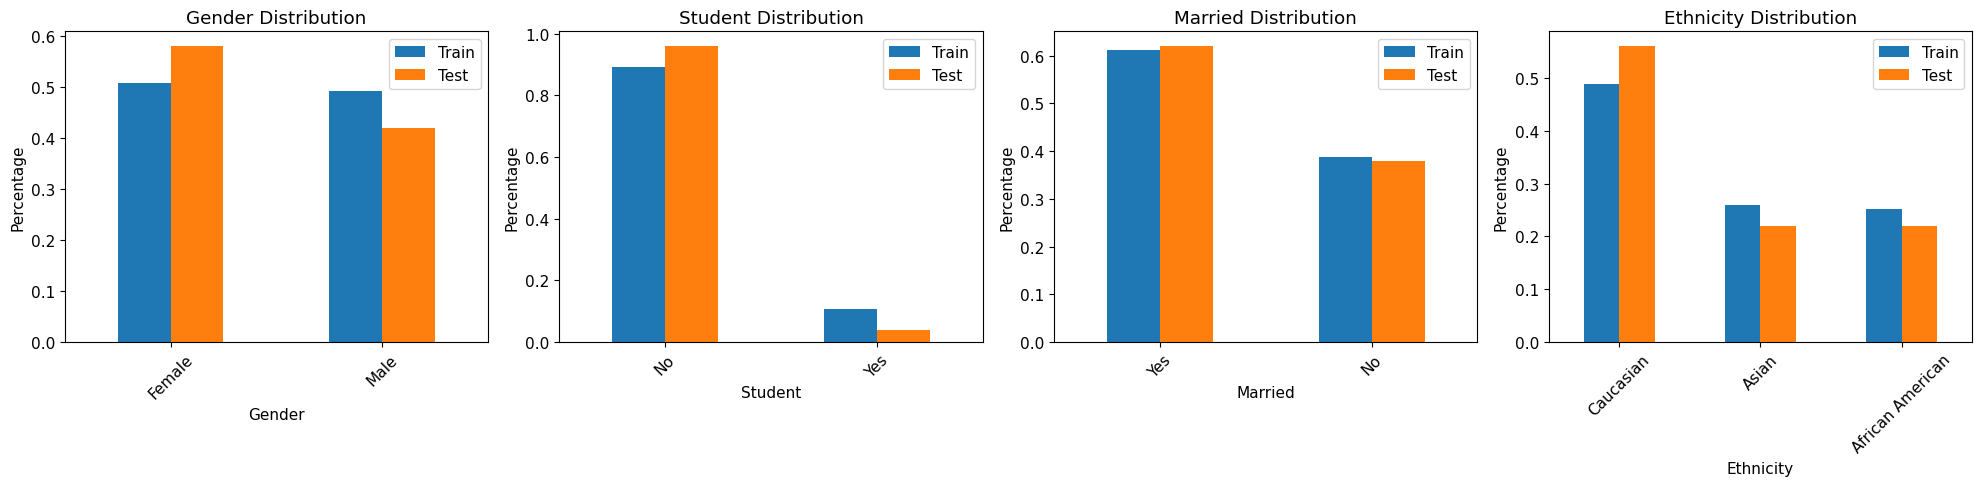

In [73]:
categorical_columns = train_data.select_dtypes(include="object").columns.to_list()
plt.rcParams.update({'font.size': 11})
num_cols = len(categorical_columns)
fig, axes = plt.subplots(1, num_cols, figsize=(num_cols*5, 5))

fig.subplots_adjust(wspace=0.5)
for i, col in enumerate(categorical_columns):
    # Concatenate train and test data
    combined_data = pd.concat([train_data[col].value_counts(normalize=True).rename('Train'), 
                               test_data[col].value_counts(normalize=True).rename('Test')], axis=1)
    
    combined_data.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 1.2.2 Numerical Features

In [12]:
train_data.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,44.914577,4718.445714,353.797143,2.920000,55.074286,13.545714,521.708571
std,34.637355,2265.483549,151.826932,1.362368,17.048395,3.099482,456.341595
min,10.354000,855.000000,93.000000,1.000000,23.000000,6.000000,0.000000
25%,21.272000,3096.500000,249.250000,2.000000,41.000000,11.000000,69.250000
50%,33.325500,4612.500000,344.000000,3.000000,55.000000,14.000000,459.500000
75%,56.889000,5834.500000,434.750000,4.000000,69.000000,16.000000,845.250000
max,186.634000,13414.000000,949.000000,8.000000,91.000000,20.000000,1809.000000


In [13]:
test_data.describe()

,Income,Limit,Rating,Cards,Age,Education
count,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000
mean,47.349040,4855.680000,362.940000,3.220000,59.82000,12.780000
std,39.551203,2609.824253,175.154906,1.418392,18.24067,3.253193
min,10.588000,1335.000000,129.000000,1.000000,24.00000,5.000000
25%,18.012750,2916.250000,229.750000,2.000000,43.75000,10.000000
50%,31.573000,4890.000000,364.500000,3.000000,63.50000,13.000000
75%,62.533000,6201.000000,448.000000,4.000000,75.75000,15.000000
max,182.728000,13913.000000,982.000000,9.000000,98.00000,19.000000


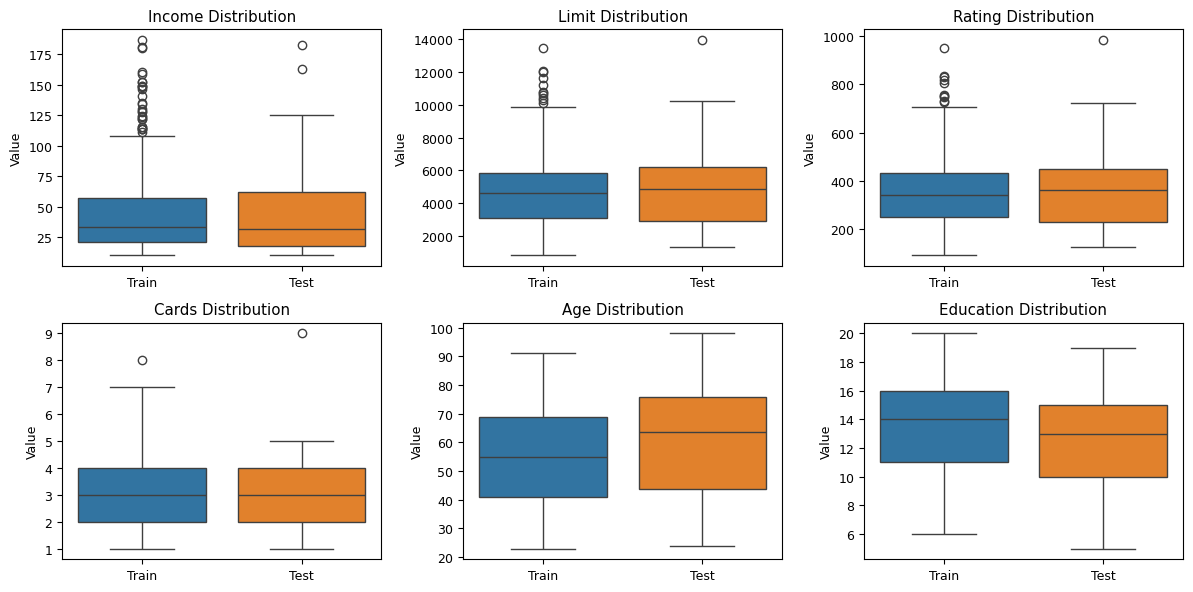

In [14]:
numerical_columns = test_data.select_dtypes(exclude="object").columns.tolist()
plt.rcParams.update({'font.size': 9})
num_cols = len(numerical_columns)
fig, axes = plt.subplots(2, int(num_cols / 2), figsize=(12, 2*3))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(numerical_columns):
    row_index = i // 3  # Calculate the row index
    col_index = i % 3   # Calculate the column index

    # Concatenate train and test data
    combined_data = pd.concat([train_data[col], test_data[col]], axis=1)
    combined_data.columns = ['Train', 'Test']
    
    # Plot box plot for the feature
    sns.boxplot(data=combined_data, ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f'{col} Distribution')
    axes[row_index, col_index].set_ylabel('Value')

# Remove any empty subplot
if num_cols % 3 != 0:
    for j in range(num_cols % 3, 3):
        fig.delaxes(axes[num_rows - 1, j])

plt.tight_layout()
plt.show()

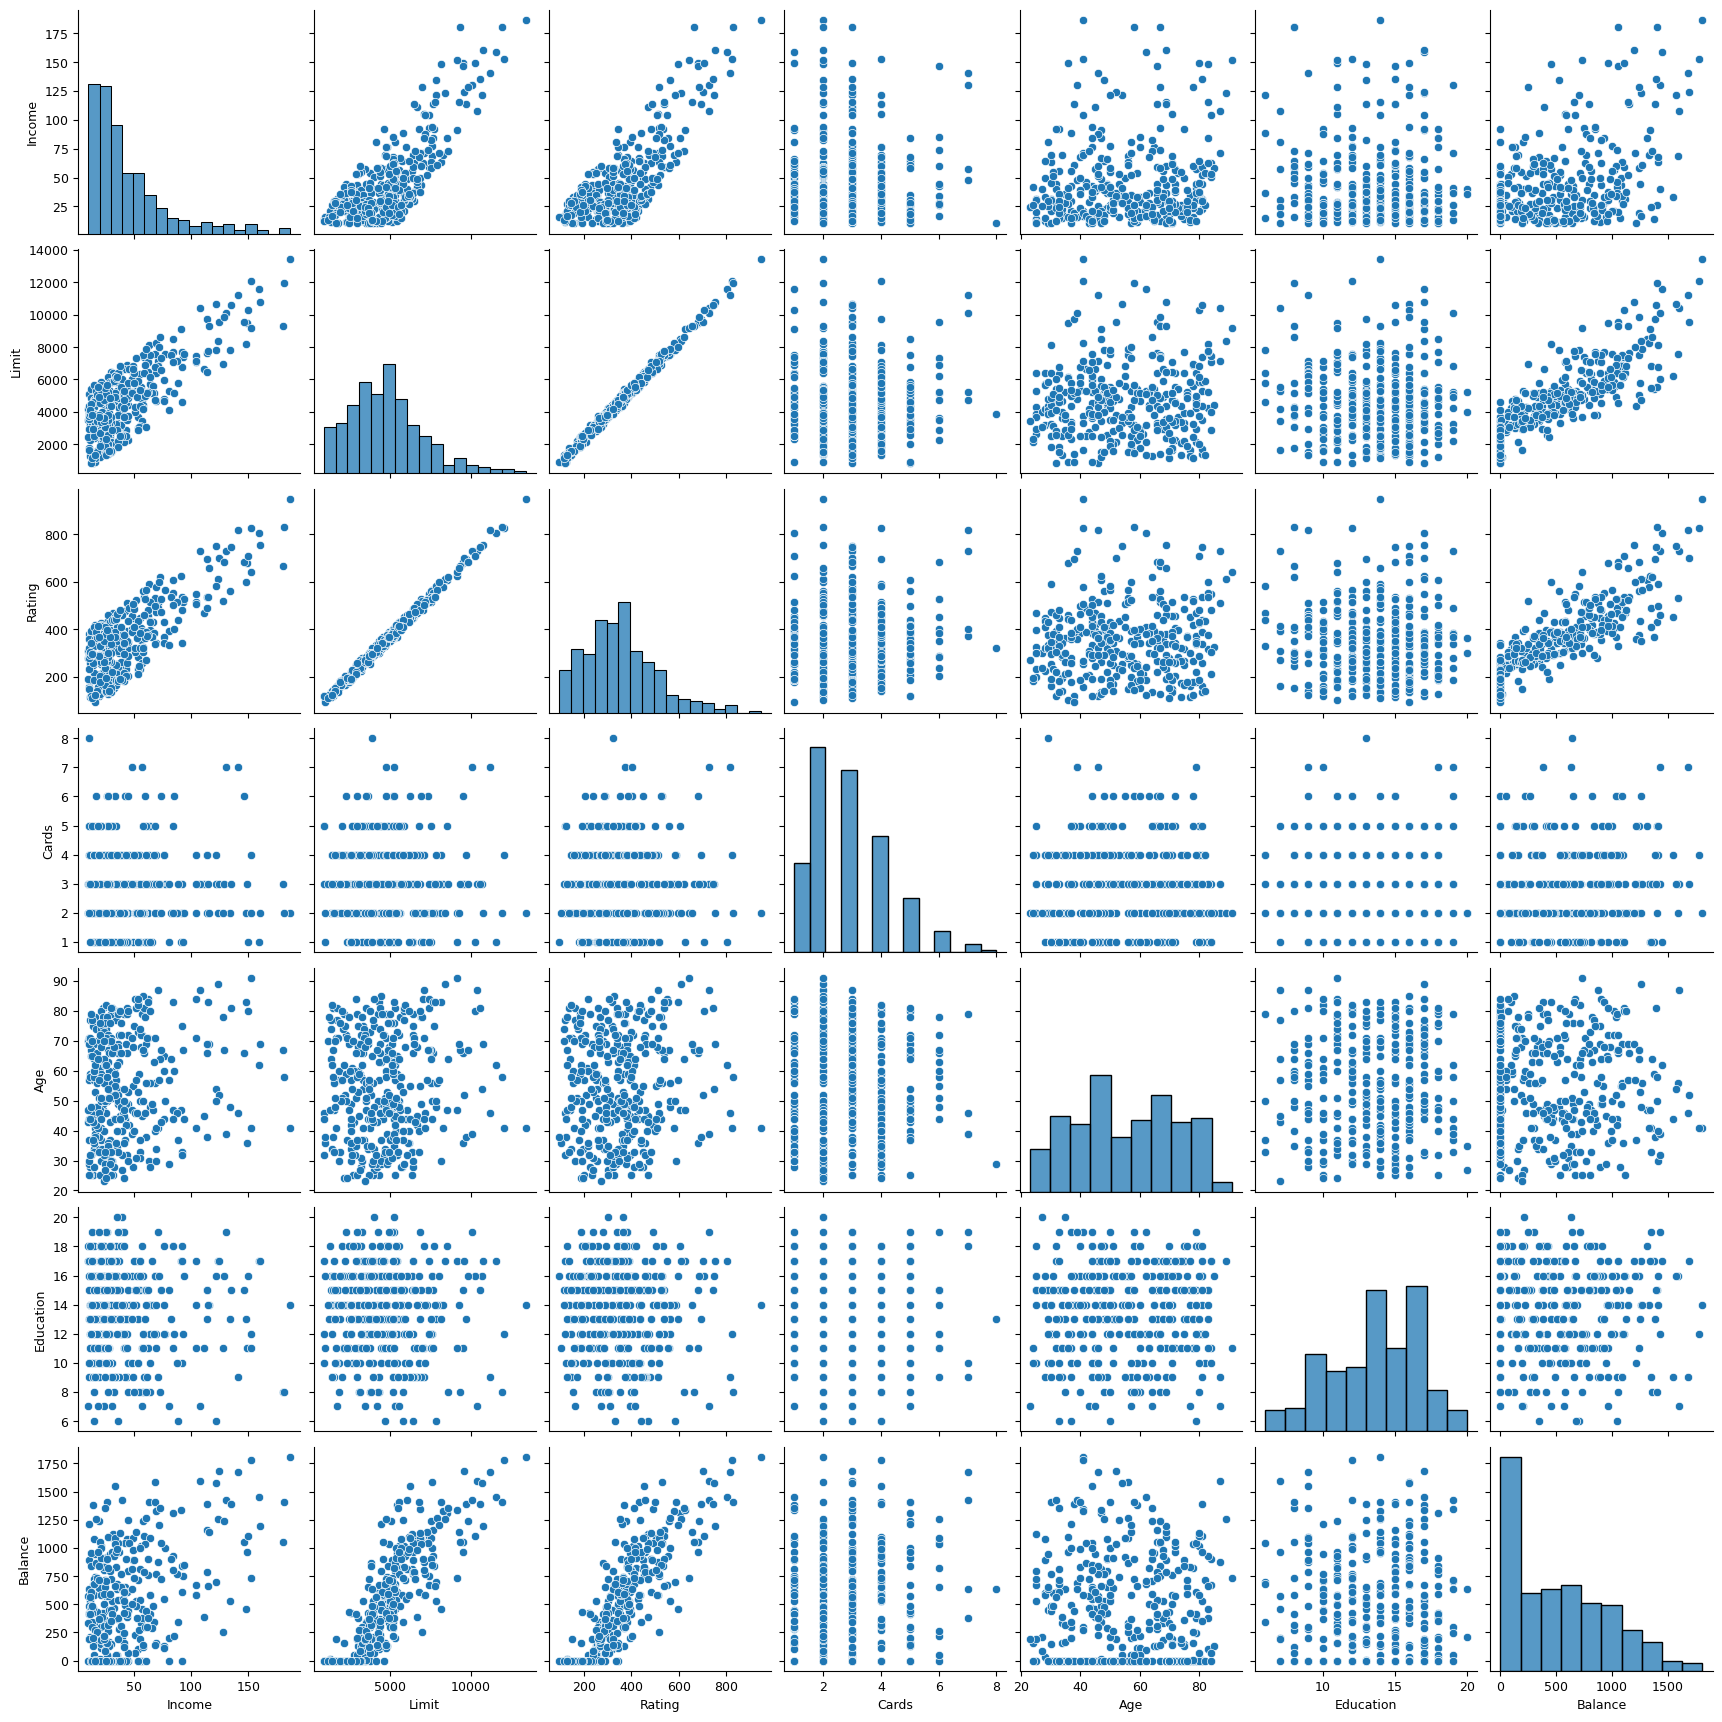

In [15]:
# Visualize distributions and relationships
sns.pairplot(train_data)
plt.show()

### 2. Preprocessing

#### 2.1 Encoding of Categorical Features

In [74]:
categorical_columns = train_data.select_dtypes(include="object").columns.to_list()
train_data = pd.get_dummies(train_data, columns=categorical_columns)

#### 2.2 Check correlation between features

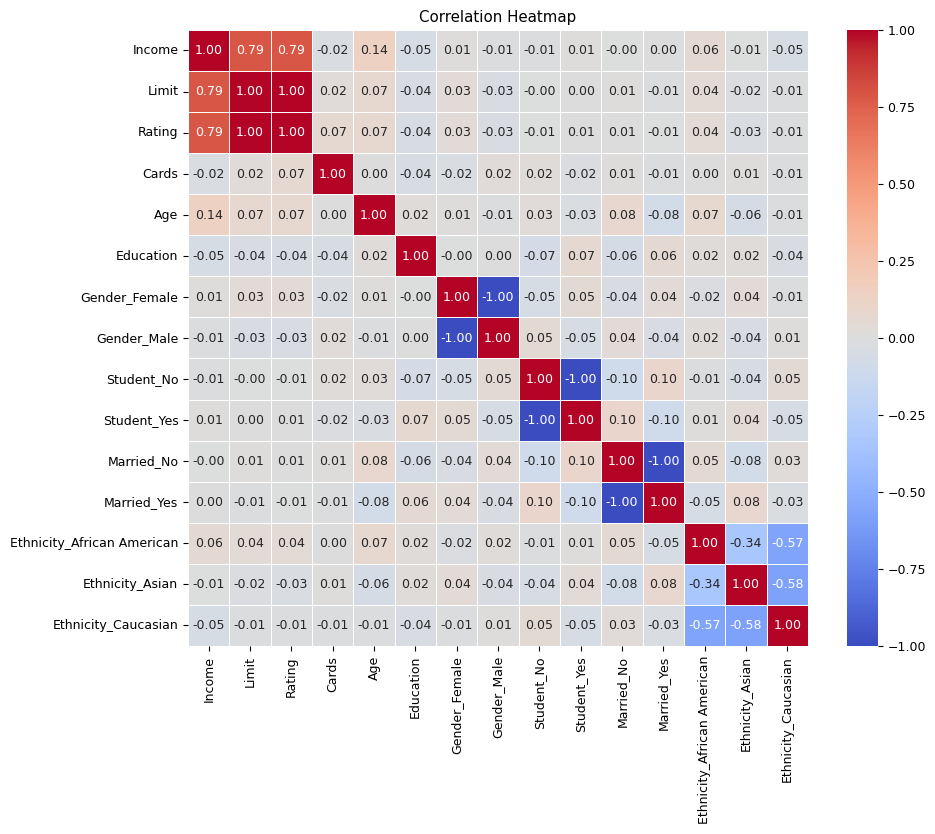

In [17]:
correlation_matrix = train_data.drop('Balance', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

'Limit', 'Income' and 'Rating'  are highly correlated with each other.

#### 2.2 Relationship of features to target

In [18]:
# See correlation of features to target
train_data.corr()['Balance'].sort_values(ascending=False)

Balance                       1.000000
Rating                        0.857591
Limit                         0.854554
Income                        0.450618
Student_Yes                   0.287136
Cards                         0.111943
Married_No                    0.048992
Gender_Female                 0.042302
Ethnicity_African American    0.007481
Ethnicity_Asian              -0.003452
Ethnicity_Caucasian          -0.003464
Education                    -0.016612
Age                          -0.023072
Gender_Male                  -0.042302
Married_Yes                  -0.048992
Student_No                   -0.287136
Name: Balance, dtype: float64

- strong (positive) correlation: Rating, Limit, and Income
- low correlation (absolute correlation < 0.1):  Married_No, Gender_Female, Ethnicity_African American,Ethnicity_Asian, Ethnicity_Caucasian, Age, Education,  Gender_Male, Married_Yes

#### 2.3 Split data into training and test set

In [19]:
X_train,X_test,y_train,y_test=train_test_split(train_data.drop(labels=['Balance'], axis=1),
    train_data['Balance'],
    test_size=0.3,
    random_state=42)

#### 2.4 Mutual Information

In [20]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)[0:20]

Rating                        0.801024
Limit                         0.764732
Income                        0.093657
Student_Yes                   0.049389
Cards                         0.042368
Ethnicity_Caucasian           0.038845
Gender_Female                 0.029954
Student_No                    0.024007
Gender_Male                   0.022103
Ethnicity_African American    0.000606
Age                           0.000000
Education                     0.000000
Married_No                    0.000000
Married_Yes                   0.000000
Ethnicity_Asian               0.000000
dtype: float64

- high mutual informatio: Rating,  Limit
- Low Mutual Information: Gender_Male, Ethnicity_Caucasian, Gender_Female, Student_Yes, Age, Ethnicity_African American, Student_No, Education, Married_No, Married_Yes, Ethnicity_Asian

Including Ethnicity also could introduce a bias  and  lead to unfair or discriminatory outcomes. 
Student  has a low mutual information but moderate correlation, so it could still provide valuable information to the model.

Candidates for removal (based on low mutual information and weak correlation):
- Married_No
- Gender_Female
- Ethnicity_African American
- Ethnicity_Asian
- Ethnicity_Caucasian
- Education
- Age
- Gender_Male
- Married_Yes



In [21]:
features_to_remove = ['Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes']

### 4. Model Training and Evaluation

To determine the best model which minimized the evaluation metric MAE, we compare different types of machine learning models and optimize parameters via grid search.
- Ridge Regression
- Random Forest Regression
- XGBoost
- MLP Regression

Moreover, removing certain features from the dataset resulted in improved prediction performance.

In [22]:
feature_subsets = [
    #("All Features", train_data.drop('Balance', axis=1)),
    ("Without " + str(features_to_remove), train_data.drop(['Balance'] + features_to_remove, axis=1)),    
]

#### 4.1 Ridge Regression

In [23]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_param_grid = {
    'ridge__alpha': [0.0001, .001, 0.1, 0.5, 1, 10]
}

for subset_name, subset_data in feature_subsets:
    print(f"Testing with subset: {subset_name}")

    # Split the subset data into training and test sets
    X_train,X_test,y_train,y_test=train_test_split(subset_data,train_data['Balance'],test_size=0.3,random_state=42)
    
    # Perform grid search
    ridge_grid = GridSearchCV(ridge_pipeline, ridge_param_grid,scoring='neg_mean_absolute_error', cv=5)
    
    # Train the model
    ridge_grid.fit(X_train, y_train)
    
    # Make predictions using the best model
    y_pred_ridge = ridge_grid.best_estimator_.predict(X_test)
  
    # Calculate Mean Absolute Error (MAE) 
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

    
    # Get the best parameters 
    ridge_best_params = ridge_grid.best_params_

    # Calculate R-squared score
    r2_ridge = r2_score(y_test, y_pred_ridge)


    print("Ridge Regression MAE:", mae_ridge)
    print("Ridge Regression R-squared score:", r2_ridge)
    print("Ridge Regression Best Parameters:", ridge_best_params)
    print("\n")

Testing with subset: Without ['Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes']
Ridge Regression MAE: 77.06298939050005
Ridge Regression R-squared score: 0.9581377633748012
Ridge Regression Best Parameters: {'ridge__alpha': 0.0001}




#### 4.2 Random Forest Regression

In [24]:
rf_pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 2, 10, 20],
    'rf__min_samples_leaf' : [1,2,4],
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
}

for subset_name, subset_data in feature_subsets:
    print(f"Testing with subset: {subset_name}")

    X_train,X_test,y_train,y_test=train_test_split(subset_data,train_data['Balance'],test_size=0.3,random_state=42)

    rf_grid = GridSearchCV(rf_pipeline, rf_param_grid,scoring='neg_mean_absolute_error',  cv=5)

    rf_grid.fit(X_train, y_train)
    
    y_pred_rf = rf_grid.best_estimator_.predict(X_test)

    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    
    rf_best_params = rf_grid.best_params_

    r2_rf = r2_score(y_test, y_pred_rf)

    print("Random Forest MAE:", mae_rf)
    print("Random Forest R-squared score:", r2_rf)
    print("Random Forest Best Parameters:", rf_best_params)

    print("\n")


Testing with subset: Without ['Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes']
Random Forest MAE: 61.47866666666667
Random Forest R-squared score: 0.9500944553434227
Random Forest Best Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}




#### 4.3 XGBoost

In [25]:
xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor(random_state=42))
])


xgb_param_grid = {
    'xgb__n_estimators': [ 100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'xgb__subsample': [0.6, 0.8, 1.0], 
    'xgb__colsample_bytree': [0.6, 0.8, 1.0], 
     'xgb__gamma': [0, 0.1, 0.2], 
}

for subset_name, subset_data in feature_subsets:
    print(f"Testing with subset: {subset_name}")

    X_train,X_test,y_train,y_test=train_test_split(subset_data,train_data['Balance'],test_size=0.3,random_state=42)

    xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid,scoring='neg_mean_absolute_error',  cv=5)

    
    xgb_grid.fit(X_train, y_train)

    y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)

    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

    xgb_best_params = xgb_grid.best_params_

    r2_xgb = r2_score(y_test, y_pred_xgb)


    print("XGBoost MAE:", mae_xgb)
    print("XGBoost R-squared score:", r2_xgb)
    print("XGBoost Best Parameters:", xgb_best_params)
    print("\n")

Testing with subset: Without ['Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes']
XGBoost MAE: 47.87878116312481
XGBoost R-squared score: 0.9677274582340493
XGBoost Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.2, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 300, 'xgb__subsample': 0.6}




#### 4.4 MLP

In [38]:

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(random_state=42))
])


layer_size = [8, 16, 32, 64]
network_sizes = []

# Generate all combinations with 3 or 4 hidden layers
#for num_hidden_layers in [3, 4]:
#    network_sizes += list(product(layer_size, repeat=num_hidden_layers))
                                  
mlp_param_grid = {
   'mlp__hidden_layer_sizes': [(8,16,32), (16,32,16), (8,16,32,16), (16,32,32)],
    #'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
     #'mlp__alpha': [0.0001],
    'mlp__max_iter': [1800],
}




for subset_name, subset_data in feature_subsets:
    print(f"Testing with subset: {subset_name}")

    X_train,X_test,y_train,y_test=train_test_split(subset_data,train_data['Balance'],test_size=0.3,random_state=42)

    mlp_grid = GridSearchCV(mlp_pipeline, mlp_param_grid, scoring='neg_mean_absolute_error', cv=5)

    mlp_grid.fit(X_train, y_train)
    
    y_pred_mlp = mlp_grid.best_estimator_.predict(X_test)
    
    mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
    

    mlp_best_params = mlp_grid.best_params_

    r2_mlp = r2_score(y_test, y_pred_mlp)

    print("MLP Regressor MAE:", mae_mlp)
    print("MLP Regressor R-squared score:", r2_mlp)
    print("MLP Regressor Best Parameters:", mlp_best_params)
    print("\n") 


Testing with subset: Without ['Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes']


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perce

MLP Regressor MAE: 16.503886617198344
MLP Regressor R-squared score: 0.9978297951148777
MLP Regressor Best Parameters: {'mlp__hidden_layer_sizes': (8, 16, 32, 16), 'mlp__max_iter': 1800}




The MLP provided the best result.

### 5. Train final model
Train the best model on entire training data set

In [75]:
final_model =  Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(8,16,32,16), max_iter=1800))
     ])


In [76]:
X = train_data.drop(['Balance'] + features_to_remove, axis=1)
y = train_data['Balance']
final_model.fit(X, y)

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1800) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(8, 16, 32, 16),
                              max_iter=1800))])

### 6. Prediction

In [77]:
test_data = pd.get_dummies(test_data, columns=categorical_columns)
X_test = test_data.drop(features_to_remove, axis=1)

In [78]:
predictions = final_model.predict(X_test)

In [79]:
submission_df = pd.DataFrame({'ID': X_test.index, 'Expected': predictions})
submission_df.to_csv('submission.csv', index=False)